# Лабораторная работа 2: «Разработка сверточной нейронной сети с использованием PyTorch»

## Цели работы
Цель работы — разработать и обучить сверточную нейронную сеть для задачи классификации изображений на наборе данных CIFAR-10 с использованием фреймворка PyTorch.

## Задачи работы
Выполнение лабораторной работы предполагает решение следующих задач:

1. Загрузить набор данных CIFAR-10 и выполнить предобработку данных, если это необходимо.
2. Реализовать сверточную нейронную сеть с использованием фреймворка PyTorch.
3. Выбрать подходящую функцию потерь и настроить гиперпараметры обучения.
4. Обучить реализованную нейронную сеть и провести оценку качества её работы.


## План работы
1. Загрузить и обработать данные (CIFAR-10)
2. Демонстрация примеров изображений и меток
3. Реализация сверточной нейронной сети
4. Настройка функции потерь, оптимизатора и гиперпараметров
5. Цикл обучения с вывободом ошибки и точности по эпохам
6. Оценка на тестовом наборе и построение графика ошибки

- Набор CIFAR-10 содержит 60000 цветных изображений 32х32 пикселя, разделенных на 10 классов.
- Варианты предобработки включают нормализацию и аугментации.
- Архитектура сети: последовательность сверточных блоков с нормализацией и ReLU, пулы для уменьшения размерности и адаптивный pooling перед полносвязным слоем.
- Для классификации был выбран критерий CrossEntropyLoss и оптимизатор Adam.
- По завершению обучения выводится ошибка и точность на тренировачном наборе по эпохам; затем - ошибка и точность на тестовом наборе.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import time

In [13]:
# Фиксируем device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


Используем стандартные преобразования: перевод в тензор и нормализацию.

In [14]:
batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = train_dataset.classes
print('Classes:', classes)

Files already downloaded and verified
Files already downloaded and verified
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Несколько примеров из тренировачного набора.

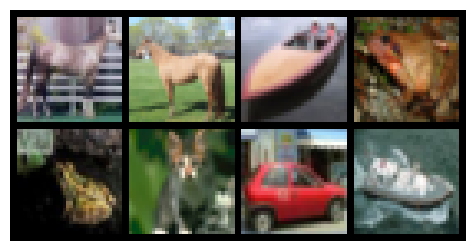

Labels: ['horse', 'horse', 'ship', 'frog', 'frog', 'cat', 'automobile', 'ship']


In [ ]:
import torchvision.utils as vutils

def imshow_batch(batch, mean=(0.4914,0.4822,0.4465), std=(0.2470,0.2435,0.2616)):
    imgs, labels = batch
    # денормализуем
    imgs = imgs.clone()
    for i in range(3):
        imgs[:, i, :, :] = imgs[:, i, :, :] * std[i] + mean[i]
    grid = vutils.make_grid(imgs[:8], nrow=4)
    npimg = grid.numpy()
    plt.figure(figsize=(6,3))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    print('Labels:', [classes[l] for l in labels[:8]])

dataiter = iter(train_loader)
batch = next(dataiter)
imshow_batch(batch)

In [16]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, padding=1):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.seq(x)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.layer1 = ConvBlock(3, 64)
        self.pool1 = nn.MaxPool2d(2,2) # 32->16
        self.layer2 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2,2) # 16->8
        self.layer3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2,2) # 8->4
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256, num_classes)
    def forward(self, x):
        x = self.layer1(x)
        x = self.pool1(x)
        x = self.layer2(x)
        x = self.pool2(x)
        x = self.layer3(x)
        x = self.pool3(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

In [17]:
model = SimpleCNN(num_classes=len(classes)).to(device)
print(model)

SimpleCNN(
  (layer1): ConvBlock(
    (seq): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): ConvBlock(
    (seq): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )

Используем CrossEntropyLoss и оптимизатор Adam. Гиперпараметры ниже:

In [18]:
lr = 0.001
epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

В процессе обучения выводим ошибку и точность на тренировачном наборе по каждой эпохе. Также сохраним значения ошибки для построения графика.

In [19]:
train_losses = []
train_accuracies = []

for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    t0 = time.time()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data).item()
        total += inputs.size(0)
    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    t1 = time.time()
    print(f'Эпоха {epoch:2d}/{epochs}  Время: {t1-t0:.1f}s Ошибка: {epoch_loss:.4f} Точность: {epoch_acc:.4f}')

Эпоха  1/15  Время: 15.0s Ошибка: 1.1434 Точность: 0.5855
Эпоха  2/15  Время: 15.2s Ошибка: 0.7372 Точность: 0.7426
Эпоха  3/15  Время: 15.5s Ошибка: 0.5692 Точность: 0.8012
Эпоха  4/15  Время: 15.2s Ошибка: 0.4675 Точность: 0.8401
Эпоха  5/15  Время: 15.4s Ошибка: 0.3890 Точность: 0.8663
Эпоха  6/15  Время: 15.2s Ошибка: 0.3202 Точность: 0.8899
Эпоха  7/15  Время: 15.2s Ошибка: 0.2640 Точность: 0.9092
Эпоха  8/15  Время: 15.3s Ошибка: 0.2095 Точность: 0.9281
Эпоха  9/15  Время: 15.3s Ошибка: 0.1646 Точность: 0.9440
Эпоха 10/15  Время: 15.2s Ошибка: 0.1307 Точность: 0.9564
Эпоха 11/15  Время: 15.5s Ошибка: 0.1007 Точность: 0.9658
Эпоха 12/15  Время: 15.5s Ошибка: 0.0866 Точность: 0.9707
Эпоха 13/15  Время: 15.5s Ошибка: 0.0637 Точность: 0.9798
Эпоха 14/15  Время: 15.3s Ошибка: 0.0631 Точность: 0.9788
Эпоха 15/15  Время: 15.2s Ошибка: 0.0502 Точность: 0.9827


Выведем ошибку и точность на тестовом наборе, а также построим график ошибки по эпохам.


Результаты на тесте:
Ошибка: 0.7084 Точность: 0.8325


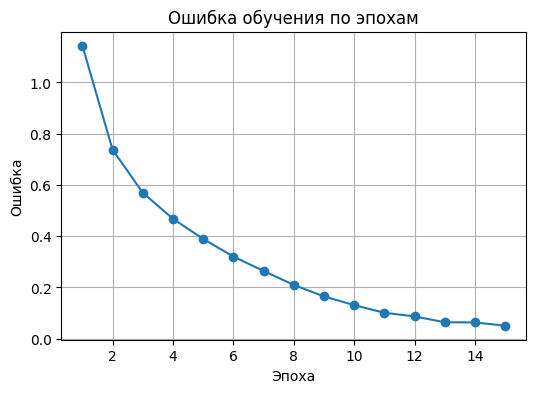

In [21]:
model.eval()

total = 0
correct = 0
test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data).item()
        total += inputs.size(0)

test_loss = test_loss / total
test_acc = correct / total
print(f"\nРезультаты на тесте:")
print(f'Ошибка: {test_loss:.4f} Точность: {test_acc:.4f}')

# График loss по эпохам
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_losses, marker='o')
plt.title('Ошибка обучения по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.grid(True)
plt.show()